# Endometrium analysis - clusters visualization

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './data/cellphoneDB/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

# Prepare INPUT

## Load andata

In [ ]:
adata = sc.read('data/endometrium-N2-clean-manifold.h5ad')
adata.X.shape

### Load cell clusters annotation

In [ ]:
meta = pd.read_csv('data/cell_annotations/endometrium_cellannotation_clean_20200420.csv')
meta = meta.set_index('index')
meta.cell_annotation = meta.cell_annotation.str.replace('\/', '-')
meta.cell_annotation = meta.cell_annotation.str.replace(' ', '_')

Merge epithelial proliferative and exclude epithelial clusters LHX1 and KRT5 as we think are contaminants

In [ ]:
pro_idx = np.array([ 'epithelial_proliferative' in i for i in meta['cell_annotation'] ])
meta.at[ pro_idx , 'cell_annotation'] = 'epithelial_proliferative'

meta = meta[meta['cell_annotation'] != 'epithelial_KRT5']
meta = meta[meta['cell_annotation'] != 'epithelial_LHX1']

### Transfer cluster annotation labels

Remove barcodes not in meta

In [61]:
barcodes = meta.index.tolist()
adata = adata[[ i in barcodes for i in adata.obs_names]]

Now transfer labels

Trying to set attribute `.obs` of view, making a copy.
... storing 'clusters' as categorical


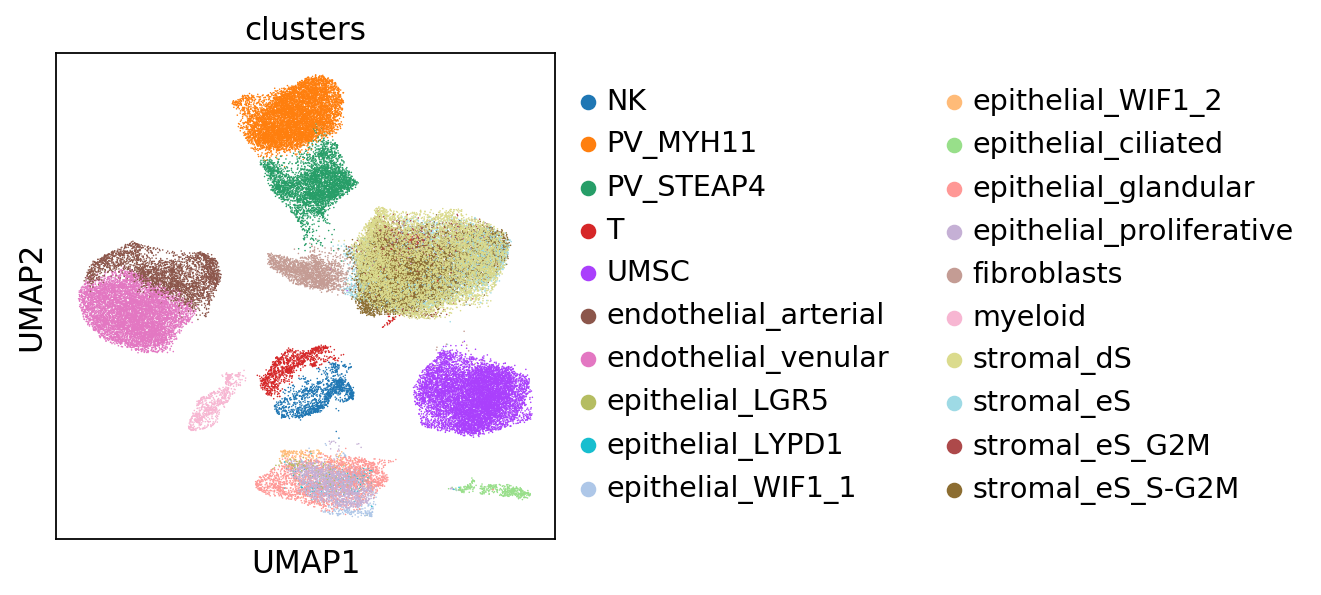

In [62]:
cell_annot = meta['cell_annotation'].to_dict()
adata.obs['clusters'] = [ cell_annot[str(i)] for i in adata.obs_names ]
sc.pl.umap(adata, color=['clusters'])

## Remove endothelial, PV and UMSC

... as they are not in contact with epithelial.

Keep:
- Other epi
- Fibro and all stromal
- Mac
- T cells
- NK


In [63]:
adata.obs['clusters'].cat.categories

Index(['NK', 'PV_MYH11', 'PV_STEAP4', 'T', 'UMSC', 'endothelial_arterial',
       'endothelial_venular', 'epithelial_LGR5', 'epithelial_LYPD1',
       'epithelial_WIF1_1', 'epithelial_WIF1_2', 'epithelial_ciliated',
       'epithelial_glandular', 'epithelial_proliferative', 'fibroblasts',
       'myeloid', 'stromal_dS', 'stromal_eS', 'stromal_eS_G2M',
       'stromal_eS_S-G2M'],
      dtype='object')

In [64]:
adata = adata[[i not in ['PV_MYH11', 'PV_STEAP4', 'endothelial_arterial', 'endothelial_venular', 'UMSC'] for i in adata.obs['clusters'] ]]
adata.obs['clusters'] = adata.obs['clusters'].cat.remove_unused_categories()
adata.obs['clusters'].cat.categories

Trying to set attribute `.obs` of view, making a copy.


Index(['NK', 'T', 'epithelial_LGR5', 'epithelial_LYPD1', 'epithelial_WIF1_1',
       'epithelial_WIF1_2', 'epithelial_ciliated', 'epithelial_glandular',
       'epithelial_proliferative', 'fibroblasts', 'myeloid', 'stromal_dS',
       'stromal_eS', 'stromal_eS_G2M', 'stromal_eS_S-G2M'],
      dtype='object')

## Save gene expression 

Generate the normalized but not log transformed matrix

In [65]:
adata.X.shape

(31991, 26245)

In [66]:
adata_count = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False)
sc.pp.filter_genes(adata_count, min_cells = 5)
sc.pp.filter_cells(adata_count, min_genes = 200)
sc.pp.normalize_per_cell(adata_count, counts_per_cell_after=1e4)
adata_count.X.shape

(31991, 24079)

Use only genes in cellphoneDB to speed up processes

In [67]:
# # load cellphoneDB genes
# genes_df = pd.read_csv('~/farm/CellPhoneDB-data_smallmolecules/data/gene_input_all.csv')
# genes_in_cellphoneDB = list(genes_df['hgnc_symbol'])
# # filter genes in cellphoneDB
# adata_count.var['is_in_cellphoneDB'] = [ i in genes_in_cellphoneDB for i in adata_count.var_names ]
# print(adata_count.var['is_in_cellphoneDB'].value_counts(normalize=True))
# is_in_cellphoneDB = adata_count.var["is_in_cellphoneDB"]
# adata_count = adata_count[:, is_in_cellphoneDB]
# adata_count.X.shape

Save as csv

In [68]:
t = adata_count.X.toarray().T
# Set cell ids as column index and gene ids as row index
df_expr_matrix = pd.DataFrame(data=t, columns= adata_count.obs.index, index=adata_count.var_names)
df_expr_matrix.to_csv('data/cellphoneDB/counts2.csv')

## Save meta

In [37]:
df_meta = pd.DataFrame(data={'Cell':list(adata_count.obs.index),
                             'cell_type':[ 'celltype_'+str(i) for i in adata_count.obs['clusters']] })
df_meta.set_index('Cell', inplace=True)
df_meta.to_csv('data/cellphoneDB/meta.tsv', sep = '\t')

# Run cellphoneDB

``
source ~/cpdb-venv/bin/activate
``

## Create database
``
cellphonedb database generate 
    --result-path database 
    --user-gene ~/farm/CellPhoneDB-data_smallmolecules/data/gene_input_all.csv 
    --user-complex ~/farm/CellPhoneDB-data_smallmolecules/data/sources/complex_curated.csv 
    --user-interactions ~/farm/CellPhoneDB-data_smallmolecules/data/sources/interaction_curated.csv
``

## Run cellphone without statistical analysis - just get expressed interactions
``
cellphonedb method analysis 
    /home/jovyan/farm/endometrium/data/cellphoneDB/meta.tsv 
    /home/jovyan/farm/endometrium/data/cellphoneDB/counts.csv 
    --database /home/jovyan/farm/endometrium/data/cellphoneDB/database/cellphonedb_user_2020-04-27-11_59.db 
    --counts-data hgnc_symbol 
    --output-path /home/jovyan/farm/endometrium/data/cellphoneDB/out/
    --threshold 0
``


# Compute DEGs

Process data to run limma

In [38]:
adata_count = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs)
sc.pp.filter_genes(adata_count, min_cells = 5)
sc.pp.filter_cells(adata_count, min_genes = 200)
sc.pp.normalize_per_cell(adata_count, counts_per_cell_after=1e4)
sc.pp.log1p(adata_count)
print(adata_count.obs['clusters'].values.describe())
adata_count.X.shape

                          counts     freqs
categories                                
NK                          1295  0.040480
T                           1026  0.032072
epithelial_LGR5              101  0.003157
epithelial_LYPD1             394  0.012316
epithelial_WIF1_1            199  0.006220
epithelial_WIF1_2            240  0.007502
epithelial_ciliated          428  0.013379
epithelial_glandular        1964  0.061392
epithelial_proliferative    1672  0.052265
fibroblasts                 1940  0.060642
myeloid                      728  0.022756
stromal_dS                  6906  0.215873
stromal_eS                  5381  0.168204
stromal_eS_G2M               805  0.025163
stromal_eS_S-G2M            8912  0.278578


(31991, 24079)

Downsample clusters with > n cells - take n cells

In [39]:
import random
from itertools import chain

# Find clusters with > n cells
n = 2000
cluster_counts = adata_count.obs['clusters'].values.describe()
cl2downsample = cluster_counts.index[ cluster_counts['counts'] > n ]

# save all barcode ids from small clusters
holder = []
holder.append( adata_count.obs_names[[ i not in cl2downsample for i in adata_count.obs['clusters'] ]] ) 

# randomly sample n cells in the cl2downsample
for cl in cl2downsample:
    print(cl)
    cl_sample = adata_count[[ i == cl for i in adata_count.obs['clusters'] ]].obs_names
    # n = int(round(len(cl_sample)/2, 0))
    cl_downsample = random.sample(set(cl_sample), n )
    holder.append(cl_downsample)
    
# samples to include
samples = list(chain(*holder))

# Filter adata_count
adata_count = adata_count[[ i in samples for i in adata_count.obs_names ]]
adata_count.X.shape

stromal_dS
stromal_eS
stromal_eS_S-G2M


(16792, 24079)

In [40]:
print(adata_count.obs['clusters'].values.describe())

                          counts     freqs
categories                                
NK                          1295  0.077120
T                           1026  0.061101
epithelial_LGR5              101  0.006015
epithelial_LYPD1             394  0.023464
epithelial_WIF1_1            199  0.011851
epithelial_WIF1_2            240  0.014293
epithelial_ciliated          428  0.025488
epithelial_glandular        1964  0.116960
epithelial_proliferative    1672  0.099571
fibroblasts                 1940  0.115531
myeloid                      728  0.043354
stromal_dS                  2000  0.119104
stromal_eS                  2000  0.119104
stromal_eS_G2M               805  0.047939
stromal_eS_S-G2M            2000  0.119104


prepare objects for R

In [41]:
t = adata_count.X.toarray().T
df = pd.DataFrame(data=t, columns= adata_count.obs.index, index=adata_count.var_names)

In [42]:
meta_df = pd.DataFrame(data={'Cell':list(adata_count.obs.index),
                             'cell_type':[ str(i) for i in adata_count.obs['clusters']],
                             'sample':[ str(i) for i in adata_count.obs['individual']],
                             'covariate':[ i for i in adata_count.obs['type']]})
meta_df.head()

,Cell,cell_type,sample,covariate
0,4861STDY7309368_AAACCTGCACCTCGGA,stromal_eS,A10,CBTM
1,4861STDY7309368_AAACGGGAGCTCCTTC,stromal_eS,A10,CBTM
2,4861STDY7309368_AAACGGGCATCACGAT,stromal_eS,A10,CBTM
3,4861STDY7309368_AAAGATGAGTTCGCAT,fibroblasts,A10,CBTM
4,4861STDY7309368_AACACGTTCAGTTGAC,stromal_eS,A10,CBTM


In [43]:
outpath = str(sc.settings.figdir)

In [44]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [45]:
%%R -i df -i meta_df -i outpath

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# R modifies colnames, change it back
rownames(meta_df) = gsub('-', '.', rownames(meta_df))
colnames(ex_mat) = gsub('^X', '', colnames(ex_mat))

# Intersect shared cells in meta and df
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
print(rownames(meta_df)[1:3])
print(colnames(ex_mat)[1:3])
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter low expressed genes
keep = aveLogCPM(ex_mat) > 0
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
covariate = meta_df$covariate

# For each cluster, make cluster vs rest comparison
celltypes = unique(meta_df$cell_type)
for (celltype in rev(sort(celltypes))){
    message(celltype)
    
    # Extract cells in cluster and rest
    cells_cluster = rownames(subset(meta_df, cell_type == celltype))
    cells_rest = rownames(subset(meta_df, cell_type != celltype))
    message('Cells in cluster ', length(cells_cluster), '\nCells in rest ', length(cells_rest))
    
    # build cluster_type vector
    cluster_type = rep(0, length(cells))
    names(cluster_type) = cells
    cluster_type[ cells_cluster ] = 'cluster'
    cluster_type[ cells_rest ] = 'rest'
    
    # Now tell limma how do you want to compare (i.e. cluster vs rest rest)
    design.matrix <- model.matrix(~ 0 + cluster_type)
    contrast.matrix <- makeContrasts(clVSrest = cluster_typecluster - cluster_typerest, levels = design.matrix)

    # Make model and run contrasts
    fit <- lmFit(ex_mat, design.matrix)
    fit <- contrasts.fit(fit, contrast.matrix)
    fit <- eBayes(fit)
    
    # Make a dataframe containing the important data
    results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'clVSrest')
    
    # Add and filter needed data
    results$cluster = celltype
    results$Gene = rownames(results)
    results = results[ , c('cluster', 'Gene', 'logFC', 'P.Value', 'adj.P.Val')]
    results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_cluster], 1, mean)
    results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_rest], 1, mean)
    results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_cluster], 1, function(x) sum(c(x > 0)+0) ) / length(cells_cluster)
    results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_rest], 1, function(x) sum(c(x > 0)+0) ) / length(cells_rest)
    
    # Round
    results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
    results$AveExpr_rest = round(results$AveExpr_rest, 6)
    results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
    results$percentExpr_rest = round(results$percentExpr_rest, 6)
    
    # and store it as csv file
    write.csv(results, file = paste0(outpath, '/', celltype, '_DEGs.csv'), row.names = F, col.names = T, quote = F)
    
}

[1] "4861STDY7309368_AAACCTGCACCTCGGA" "4861STDY7309368_AAACGGGAGCTCCTTC"
[3] "4861STDY7309368_AAACGGGCATCACGAT"
[1] "4861STDY7309368_AAACCTGCACCTCGGA" "4861STDY7309368_AAACGGGAGCTCCTTC"
[3] "4861STDY7309368_AAACGGGCATCACGAT"




Cells in rest 15766


Cells in rest 14792


Cells in rest 15987


Cells in rest 14792


Cells in rest 14792


Cells in rest 15497


Cells in rest 16064


Cells in rest 14852


Cells in rest 16552


Cells in rest 16593


Cells in rest 15120


Cells in rest 16398


Cells in rest 16691


Cells in rest 14828


Cells in rest 16364



# Compute DEGs within epithelial

Process data to run limma

In [46]:
adata_count = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs)

#Filter epithelials
adata_count = adata_count[['epithelial' in i for i in adata_count.obs['clusters'] ]]

sc.pp.filter_genes(adata_count, min_cells = 5)
sc.pp.filter_cells(adata_count, min_genes = 200)
sc.pp.normalize_per_cell(adata_count, counts_per_cell_after=1e4)
sc.pp.log1p(adata_count)
print(adata_count.obs['clusters'].values.describe())
adata_count.X.shape

Trying to set attribute `.var` of view, making a copy.


                          counts     freqs
categories                                
epithelial_LGR5              101  0.020208
epithelial_LYPD1             394  0.078832
epithelial_WIF1_1            199  0.039816
epithelial_WIF1_2            240  0.048019
epithelial_ciliated          428  0.085634
epithelial_glandular        1964  0.392957
epithelial_proliferative    1672  0.334534


(4998, 20744)

prepare objects for R

In [47]:
t = adata_count.X.toarray().T
df = pd.DataFrame(data=t, columns= adata_count.obs.index, index=adata_count.var_names)

In [48]:
meta_df = pd.DataFrame(data={'Cell':list(adata_count.obs.index),
                             'cell_type':[ str(i) for i in adata_count.obs['clusters']],
                             'sample':[ str(i) for i in adata_count.obs['individual']],
                             'covariate':[ i for i in adata_count.obs['type']]})
meta_df.head()

,Cell,cell_type,sample,covariate
0,4861STDY7309368_AACTTTCCAGACGTAG,epithelial_LYPD1,A10,CBTM
1,4861STDY7309368_AATCCAGTCAGAAATG,epithelial_LYPD1,A10,CBTM
2,4861STDY7309368_AATCGGTTCATGTAGC,epithelial_LYPD1,A10,CBTM
3,4861STDY7309368_ACACCAACAGGCTGAA,epithelial_LYPD1,A10,CBTM
4,4861STDY7309368_ACACCCTGTATTCGTG,epithelial_ciliated,A10,CBTM


In [49]:
outpath = str(sc.settings.figdir)+'/clusterDEGs_and_TFs/DEGs_withinEpithelial/'

In [50]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [51]:
%%R -i df -i meta_df -i outpath

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# R modifies colnames, change it back
rownames(meta_df) = gsub('-', '.', rownames(meta_df))
colnames(ex_mat) = gsub('^X', '', colnames(ex_mat))

# Intersect shared cells in meta and df
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
print(rownames(meta_df)[1:3])
print(colnames(ex_mat)[1:3])
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter low expressed genes
keep = aveLogCPM(ex_mat) > 0
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
covariate = meta_df$covariate

# For each cluster, make cluster vs rest comparison
celltypes = unique(meta_df$cell_type)
for (celltype in rev(sort(celltypes))){
    message(celltype)
    
    # Extract cells in cluster and rest
    cells_cluster = rownames(subset(meta_df, cell_type == celltype))
    cells_rest = rownames(subset(meta_df, cell_type != celltype))
    message('Cells in cluster ', length(cells_cluster))
    message('Cells in rest ', length(cells_rest))
    
    # build cluster_type vector
    cluster_type = rep(0, length(cells))
    names(cluster_type) = cells
    cluster_type[ cells_cluster ] = 'cluster'
    cluster_type[ cells_rest ] = 'rest'
    
    # Now tell limma how do you want to compare (i.e. cluster vs rest rest)
    design.matrix <- model.matrix(~ 0 + cluster_type)
    contrast.matrix <- makeContrasts(clVSrest = cluster_typecluster - cluster_typerest, levels = design.matrix)

    # Make model and run contrasts
    fit <- lmFit(ex_mat, design.matrix)
    fit <- contrasts.fit(fit, contrast.matrix)
    fit <- eBayes(fit)
    
    # Make a dataframe containing the important data
    results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'clVSrest')
    
    # Add and filter needed data
    results$cluster = celltype
    results$Gene = rownames(results)
    results = results[ , c('cluster', 'Gene', 'logFC', 'P.Value', 'adj.P.Val')]
    results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_cluster], 1, mean)
    results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_rest], 1, mean)
    results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_cluster], 1, function(x) sum(c(x > 0)+0) ) / length(cells_cluster)
    results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_rest], 1, function(x) sum(c(x > 0)+0) ) / length(cells_rest)
    
    # Round
    results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
    results$AveExpr_rest = round(results$AveExpr_rest, 6)
    results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
    results$percentExpr_rest = round(results$percentExpr_rest, 6)
    
    # and store it as csv file
    write.csv(results, file = paste0(outpath, '/', celltype, '_DEGs.csv'), row.names = F, col.names = T, quote = F)
    
}

[1] "4861STDY7309368_AACTTTCCAGACGTAG" "4861STDY7309368_AATCCAGTCAGAAATG"
[3] "4861STDY7309368_AATCGGTTCATGTAGC"
[1] "4861STDY7309368_AACTTTCCAGACGTAG" "4861STDY7309368_AATCCAGTCAGAAATG"
[3] "4861STDY7309368_AATCGGTTCATGTAGC"
